In [1]:
%matplotlib inline

from collections import defaultdict
from pathlib import Path

from cycler import cycler
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('presentation')

mpl.rcParams['figure.figsize'] = (9, 6)

In [2]:
c_to_co2 = 3.7  # 1 ton carbon = 3.7 tons CO2

# 1000 Pg = 1 Tt (t = metric ton)

# Matthews et al 2009 defined carbon climate response (CCR)
# but it's now more frequently referred to as 
# transient climate response to cumulative carbon emissions (TCRE)

# Mat2009 presented "best", 5%, and 95% confidence intervals
tcre_mat2009 = pd.Series(
    [1.5, 1.0, 2.1], 
    index=['best', 'low', 'high']
)

tcre_tons_co2_mat2009 = tcre_mat2009 / 1e12 / c_to_co2  # degrees C per ton CO2
tcre_tons_co2_mat2009

best    4.054054e-13
low     2.702703e-13
high    5.675676e-13
dtype: float64

In [3]:
# IPCC 2013 Chapter 12 pg 1108 summarizes a few estimates of CCR
# "Expert judgement based on the available evidence therefore 
#  suggests that the TCRE is *likely* between 0.8°C to 2.5°C per 
#  1000 PgC, for cumulative CO2 emissions less than about  
#  2000 PgC until the time at which temperature peaks."
# high and low are +/- 1 std dev

tcre_ipcc2013 = pd.Series(
    [1.65, 0.8, 2.5],
    index=['best', 'low', 'high']
)

tcre_tons_co2_ipcc2013 = tcre_ipcc2013 / 1e12 / c_to_co2  # degrees C per ton CO2
tcre_tons_co2_ipcc2013

best    4.459459e-13
low     2.162162e-13
high    6.756757e-13
dtype: float64

In [4]:
metric_ton_to_short_ton = 1.10231  # 1 metric ton = 1.10231 short tons

In [5]:
root_path = Path('/Users/holmgren/Documents/Renewables/TEP/TEP 2019 Carbon/data')

In [6]:
path = root_path / 'Historic Generation and Emissions no links.xlsx'
tep_generation = pd.read_excel(
    path,
    sheet_name='generation',
    index_col=0
)

def process_raw_df(df):
    out = df.T
    index = pd.to_datetime(out.index.astype(int), format='%Y')
    out.index = index
    out = out.interpolate()
    return out

tep_generation = process_raw_df(tep_generation)

tep_generation

,Total Generation,Market Purchases,Non-Market Generation
2005-01-01,1.285352e+07,1638737.000,1.121479e+07
2006-01-01,1.346662e+07,1842800.500,1.162382e+07
2007-01-01,1.407971e+07,2046864.000,1.203285e+07
2008-01-01,1.481311e+07,3358577.000,1.145453e+07
2009-01-01,1.406939e+07,3572993.000,1.049640e+07
2010-01-01,1.341278e+07,2700709.000,1.071207e+07
2011-01-01,1.360960e+07,2556751.065,1.105285e+07
2012-01-01,1.343640e+07,2184176.867,1.125222e+07
2013-01-01,1.353066e+07,2032840.647,1.149781e+07
2014-01-01,1.364063e+07,2893612.981,1.074702e+07


Text(0, 0.5, 'TEP Generation (MWh)')

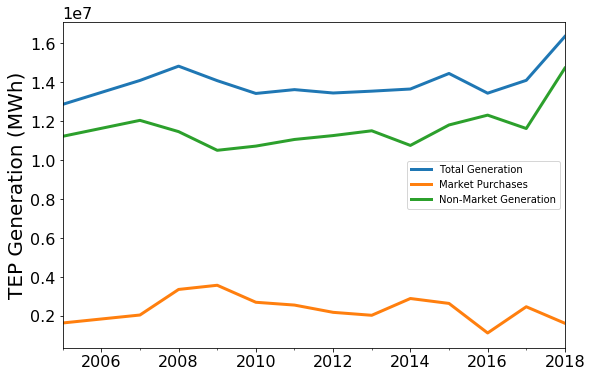

In [7]:
ax = tep_generation.plot()
ax.set_ylabel('TEP Generation (MWh)')

In [8]:
tep_emissions = pd.read_excel(
    path,
    sheet_name='emissions',
    index_col=0
)
tep_emissions = process_raw_df(tep_emissions)
tep_emissions

,Total Emissions,Market Emissions,Non-Market Emissions
2005-01-01,1.296924e+07,8.146244e+05,1.215462e+07
2006-01-01,1.308113e+07,9.264276e+05,1.215470e+07
2007-01-01,1.319302e+07,1.038231e+06,1.215479e+07
2008-01-01,1.346173e+07,1.703571e+06,1.175816e+07
2009-01-01,1.264859e+07,1.845665e+06,1.080293e+07
2010-01-01,1.205482e+07,1.342536e+06,1.071228e+07
2011-01-01,1.247021e+07,1.217947e+06,1.125226e+07
2012-01-01,1.231243e+07,1.040465e+06,1.127196e+07
2013-01-01,1.242152e+07,9.677948e+05,1.145373e+07
2014-01-01,1.184934e+07,1.377591e+06,1.047175e+07


Text(0, 0.5, 'TEP Emissions (tons of CO2)')

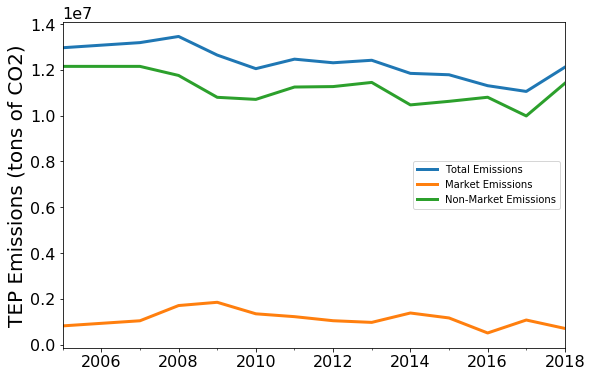

In [9]:
ax = tep_emissions.plot()
ax.set_ylabel('TEP Emissions (tons of CO2)')

In [10]:
tep_emissions_TtC = tep_emissions / 1e12 / c_to_co2

Text(0, 0.5, 'TEP Emissions (Tt C)')

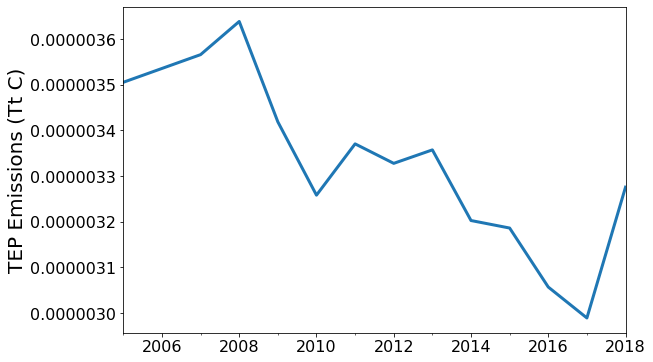

In [11]:
ax = tep_emissions_TtC['Total Emissions'].plot()
ax.set_ylabel('TEP Emissions (Tt C)')

In [12]:
tep_cumulative_emissions_TtC = tep_emissions_TtC.cumsum()

Text(0, 0.5, 'Cumulative TEP Emissions (Tt C)')

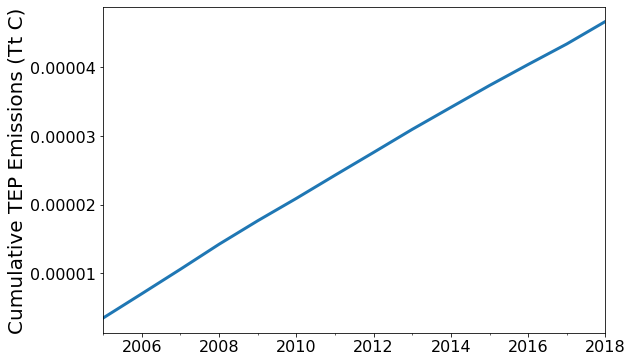

In [13]:
ax = tep_cumulative_emissions_TtC['Total Emissions'].plot()
ax.set_ylabel('Cumulative TEP Emissions (Tt C)')

Text(0, 0.5, 'Absolute TEP Delta T (degrees C)')

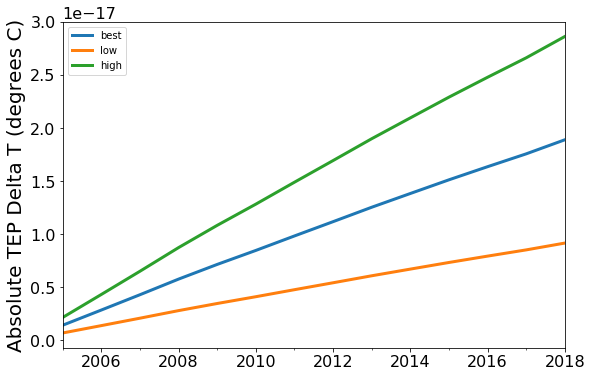

In [14]:
# surely there's a more elegant way to do this
tep_degrees_c = {k: ccr * tep_cumulative_emissions_TtC['Total Emissions'] / metric_ton_to_short_ton for k, ccr in tcre_tons_co2_ipcc2013.iteritems()}
tep_degrees_c = pd.DataFrame(tep_degrees_c)

ax = tep_degrees_c.plot()
ax.set_ylabel('Absolute TEP Delta T (degrees C)')

In [15]:
# https://www.eia.gov/energyexplained/electricity/electricity-in-the-us-generation-capacity-and-sales.php
us_generation_path = root_path / 'generation-major-source.csv'
us_generation = pd.read_csv(
    us_generation_path,
    skiprows=5,
    index_col=0
)
us_generation.index = pd.to_datetime(us_generation.index, format='%Y')
us_generation *= 1e6  # convert from billion kWh (1e9 * 1e3 = 1e12 = 1 TWh) to MWh (1e6)
us_generation['total'] = us_generation.sum(axis=1)
us_generation

,coal,natural gas,nuclear,renewables,petroleum and other,total
1950-01-01,1.550000e+08,4.500000e+07,0.0,101000000.0,34000000.0,3.350000e+08
1951-01-01,1.850000e+08,5.700000e+07,0.0,105000000.0,29000000.0,3.760000e+08
1952-01-01,1.950000e+08,6.800000e+07,0.0,110000000.0,30000000.0,4.030000e+08
1953-01-01,2.190000e+08,8.000000e+07,0.0,110000000.0,38000000.0,4.470000e+08
1954-01-01,2.390000e+08,9.400000e+07,0.0,112000000.0,32000000.0,4.770000e+08
...,...,...,...,...,...,...
2014-01-01,1.582000e+09,1.127000e+09,797000000.0,539000000.0,50000000.0,4.095000e+09
2015-01-01,1.352000e+09,1.333000e+09,797000000.0,544000000.0,50000000.0,4.076000e+09
2016-01-01,1.239000e+09,1.378000e+09,806000000.0,609000000.0,44000000.0,4.076000e+09
2017-01-01,1.206000e+09,1.296000e+09,805000000.0,687000000.0,40000000.0,4.034000e+09


Text(0, 0.5, 'US Generation (MWh)')

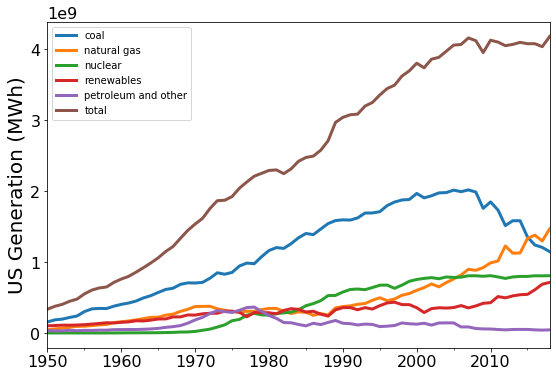

In [16]:
ax = us_generation.plot()
ax.set_ylabel('US Generation (MWh)')

In [17]:
tep_generation_fraction = tep_generation['Total Generation'] / us_generation['total']

Text(0.5, 1.0, 'TEP fraction of US Generation')

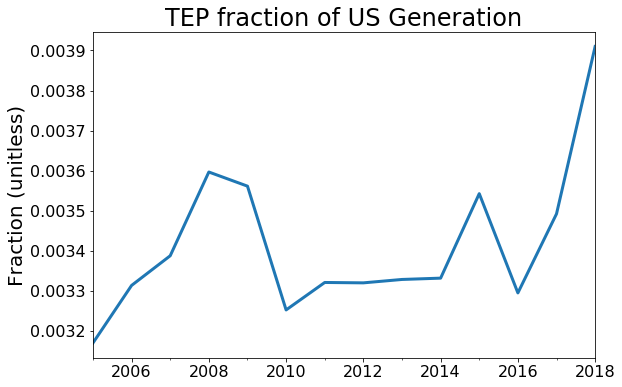

In [18]:
ax = tep_generation_fraction.dropna().plot()
ax.set_ylabel('Fraction (unitless)')
ax.set_title('TEP fraction of US Generation')

Text(0.5, 1.0, 'US like TEP Delta T')

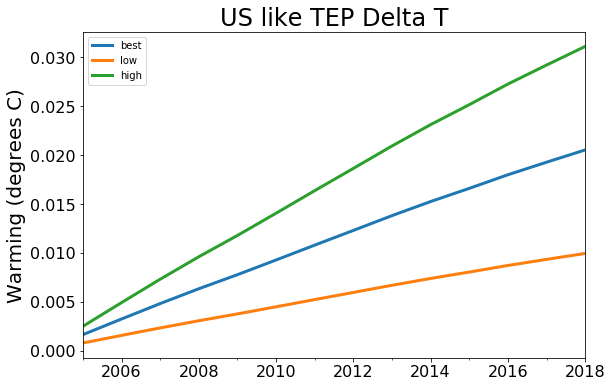

In [19]:
# need to use div to avoid broadcast
us_like_tep_emissions_TtC = tep_emissions_TtC.div(tep_generation_fraction.dropna(), axis=0)
us_like_tep_cumulative_emissions_TtC = us_like_tep_emissions_TtC.cumsum()

# surely there's a more elegant way to do this
us_like_tep_degrees_c = {k: ccr * us_like_tep_cumulative_emissions_TtC['Total Emissions'] / metric_ton_to_short_ton for k, ccr in tcre_ipcc2013.iteritems()}
us_like_tep_degrees_c = pd.DataFrame(us_like_tep_degrees_c)

ax = us_like_tep_degrees_c.plot()
ax.set_ylabel('Warming (degrees C)')
ax.set_title('US like TEP Delta T')

In [20]:
us_electric_carbon_2014 = 2040  # million metric tons
us_all_carbon_2014 = 5410
us_electric_carbon_fraction = us_electric_carbon_2014 / us_all_carbon_2014
us_electric_carbon_fraction

0.37707948243992606

Text(0.5, 1.0, 'US All Sectors like TEP Delta T')

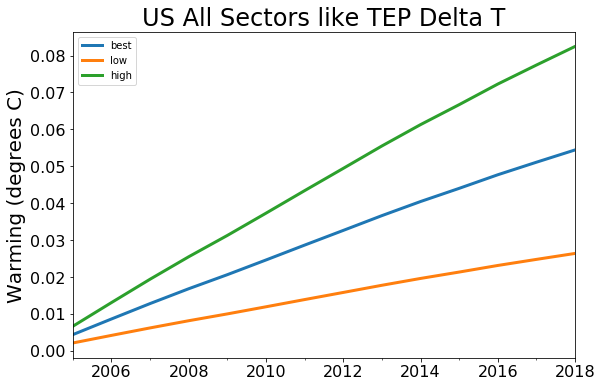

In [21]:
# this is a bad assumption for future projections!!! need to go other way and determine US electric budget instead
us_all_sectors_like_tep = us_like_tep_degrees_c / us_electric_carbon_fraction

ax = us_all_sectors_like_tep.plot()
ax.set_ylabel('Warming (degrees C)')
ax.set_title('US All Sectors like TEP Delta T')

In [22]:
# https://www.eia.gov/beta/states/states/az/rankings
# site also has energy consumption per capita, production, electric gen
us_state_carbon_path = root_path / 'us_state_carbon_emissions_2017.csv'
us_state_carbon = pd.read_csv(
    us_state_carbon_path,
    skiprows=4,
    index_col=0
)
# units of million metric tons of CO2
us_state_carbon

,Ranking,Value
State,,
TX,1,707.0
CA,2,359.0
FL,3,227.0
LA,4,226.0
PA,5,215.0
OH,6,204.0
IL,7,201.0
IN,8,176.0
NY,9,157.0


In [23]:
# https://www.eia.gov/beta/states/states/az/data/dashboard/total-energy

In [24]:
# https://www.eia.gov/beta/states/states/az/data/dashboard/electricity

In [25]:
def read_portfolio(path):
    name = path.name.split('-')[1].split('.')[0].lstrip(' ')
    
    usecols = 'D:AI'
    
    # units of MW changes
    changes = pd.read_excel(
        path,
        skiprows=5,
        nrows=4,
        index_col=0,
        usecols=usecols
    ).T

    # units of GWh
    energy = pd.read_excel(
        path,
        skiprows=13,
        nrows=18,
        index_col=0,
        usecols=usecols
    ).dropna().T

    # units of thousands of $
    financial = pd.read_excel(
        path,
        skiprows=35,
        nrows=2,
        index_col=0,
        usecols=usecols
    ).T

    # units of thousands of $
    environmental = pd.read_excel(
        path,
        skiprows=41,
        nrows=7,
        index_col=0,
        usecols=usecols
    ).dropna().T
    
    return name, changes, energy, financial, environmental

In [26]:
portfolio = 'P01aL1M1E1'
path = root_path / f'Portfolio Summary - {portfolio}.xlsx'
name, changes, energy, financial, environmental = read_portfolio(path)

Text(0, 0.5, 'Total CO2 Emissions (Short Tons)')

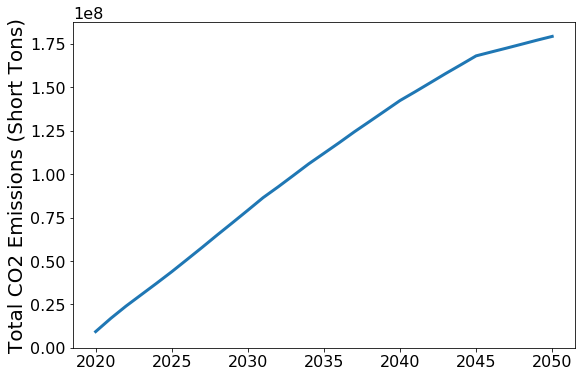

In [27]:
fig, ax = plt.subplots()
environmental.cumsum()['Total CO2 Emissions, Tons'].plot(ax=ax)
ax.set_ylim(0, None)
ax.set_ylabel('Total CO2 Emissions (Short Tons)')

In [28]:
def calc_carbon_budget_globe(
        target, 
        transient_climate_response,
        historical_warming=0.97, 
        non_CO2_temperature_effect=None,
        zero_emissions_commitment_effect=0,
        earth_system_feedback=100e9
    ):
    """Calculate global carbon budget for global temperature change
    above preindustrial period.
    
    Parameters
    ----------
    target : float
        Global temperature change target.
    transient_climate_response : float or Series
        The global mean amount of warming for each unit of 
        cumulative carbon emissions.
    historical_warming : float
        Degrees change over a preindustrial period. 
    non_CO2_temperature_effect : None or float
        Account for warming due to non-CO2 forcing such as
        sulfur dioxide. If None, set based on target.
    zero_emissions_commitment_effect : float
        Account for nonlinearity or time lag of TCRE
    earth_system_feedback : float
        Account for feedback from changes such as melting 
        of permafrost.
    
    Returns
    -------
    Series
    
    Notes
    -----
    Default values from Rogelj et al (2019).
    """
    
    # account for warming due to non-CO2 forcing
    # e.g. changes in sulfur dioxide associated with changing fuel mixes
    if non_CO2_temperature_effect is None:
        if target < 2.0:
            non_CO2_temperature_effect = 0.1  # degrees C (0 - 0.2 C 90% range) if target = 1.5 C
        else:
            non_CO2_temperature_effect = 0.2  # degrees C (0.1 - 0.4 C 90% range) if target = 2 C
    
    remaining_warming = (
        target 
        - historical_warming 
        - non_CO2_temperature_effect 
        - zero_emissions_commitment_effect
    )
    print(remaining_warming)
    print(transient_climate_response)
    carbon_budget_globe = remaining_warming / transient_climate_response - earth_system_feedback
    
    return carbon_budget_globe

carbon_budget_globe = calc_carbon_budget_globe(1.5, tcre_tons_co2_ipcc2013)
carbon_budget_globe / 1e9

0.43000000000000005
best    4.459459e-13
low     2.162162e-13
high    6.756757e-13
dtype: float64


best     864.242424
low     1888.750000
high     536.400000
dtype: float64

In [29]:
carbon_budget_globe / 1e9 - 290

best     574.242424
low     1598.750000
high     246.400000
dtype: float64

In [30]:
tcre_tons_co2_ipcc2013

best    4.459459e-13
low     2.162162e-13
high    6.756757e-13
dtype: float64

In [31]:
carbon_budget_globe = calc_carbon_budget_globe(2.0, tcre_tons_co2_ipcc2013)
carbon_budget_globe / 1e9

0.8300000000000001
best    4.459459e-13
low     2.162162e-13
high    6.756757e-13
dtype: float64


best    1761.212121
low     3738.750000
high    1128.400000
dtype: float64

In [32]:
def calc_carbon_budget_tep(target, transient_climate_response):
    """
    Parameters
    ----------
    target : array_like
        Global temperature change target.
        
    Returns
    -------
    array_like
        TEP carbon budget in short tons
    """
    carbon_budget_globe = calc_carbon_budget_globe(target, transient_climate_response)
    carbon_budget_us = carbon_budget_globe * (325 / 7700)  # assume budget based on % populuation
    carbon_budget_us_electric = carbon_budget_us * 0.3  # wild guess
    carbon_budget_tep = carbon_budget_us_electric * 0.0035  # avg fraction of generation over last 10 years
    carbon_budget_tep *= metric_ton_to_short_ton  # TEP data is in short tons
    return carbon_budget_tep

carbon_budget_tep_15 = calc_carbon_budget_tep(1.5, tcre_tons_co2_ipcc2013)
carbon_budget_tep_15

0.43000000000000005
best    4.459459e-13
low     2.162162e-13
high    6.756757e-13
dtype: float64


best    4.222030e+07
low     9.226992e+07
high    2.620441e+07
dtype: float64

In [33]:
carbon_budget_tep_20 = calc_carbon_budget_tep(2.0, tcre_tons_co2_ipcc2013)
carbon_budget_tep_20

0.8300000000000001
best    4.459459e-13
low     2.162162e-13
high    6.756757e-13
dtype: float64


best    8.603940e+07
low     1.826468e+08
high    5.512502e+07
dtype: float64

In [34]:
carbon_budgets_tep = pd.DataFrame({k: calc_carbon_budget_tep(k, tcre_tons_co2_ipcc2013) for k in (1.5, 2.0, 2.5)})
carbon_budgets_tep

0.43000000000000005
best    4.459459e-13
low     2.162162e-13
high    6.756757e-13
dtype: float64
0.8300000000000001
best    4.459459e-13
low     2.162162e-13
high    6.756757e-13
dtype: float64
1.33
best    4.459459e-13
low     2.162162e-13
high    6.756757e-13
dtype: float64


,1.5,2.0,2.5
best,4.222030e+07,8.603940e+07,1.408133e+08
low,9.226992e+07,1.826468e+08,2.956179e+08
high,2.620441e+07,5.512502e+07,9.127578e+07


In [35]:
carbon_budgets_tep.to_csv(root_path / 'carbon_budgets.csv', index_label='estimate')

In [36]:
carbon_budget_tep = carbon_budgets_tep[1.5]

In [37]:
cumulative = environmental.cumsum()['Total CO2 Emissions, Tons']

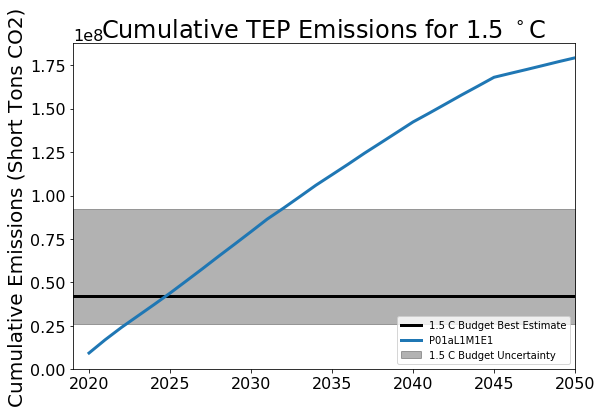

In [38]:
def cumulative_plot():
    fig, ax = plt.subplots()
    color = 'k'
    target = 1.5
    ax.axhline(carbon_budget_tep['best'], label=f'{target} C Budget Best Estimate', color=color)
    ax.fill_between((cumulative.index[0] - 1, cumulative.index[-1] + 1), carbon_budget_tep['low'], carbon_budget_tep['high'], color=color, alpha=0.3, label=f'{target} C Budget Uncertainty')
    ax.set_xlim(cumulative.index[0] - 1, cumulative.index[-1])
    ax.set_ylabel('Cumulative Emissions (Short Tons CO2)')
    ax.set_title(f'Cumulative TEP Emissions for {target} $^\circ$C')
    return fig, ax

fig, ax = cumulative_plot()
ax.plot(cumulative.index, cumulative.values, zorder=10, label=name)
ax.set_ylim(0, None)
ax.legend(loc=4)

In [39]:
portfolios = root_path.glob('Portfolio Summary - P*.xlsx')

cumulatives = {}
for portfolio in portfolios:
    print(portfolio)
    name, changes, energy, financial, environmental = read_portfolio(portfolio)
    cumulative = environmental.cumsum()['Total CO2 Emissions, Tons']
    cumulatives[name] = cumulative
    
cumulatives = pd.DataFrame(cumulatives)

/Users/holmgren/Documents/Renewables/TEP/TEP 2019 Carbon/data/Portfolio Summary - P16aL1M1E1.xlsx
/Users/holmgren/Documents/Renewables/TEP/TEP 2019 Carbon/data/Portfolio Summary - P06aL1M1E1.xlsx
/Users/holmgren/Documents/Renewables/TEP/TEP 2019 Carbon/data/Portfolio Summary - P02aL1M1E1.xlsx
/Users/holmgren/Documents/Renewables/TEP/TEP 2019 Carbon/data/Portfolio Summary - P01aL1M1E1.xlsx


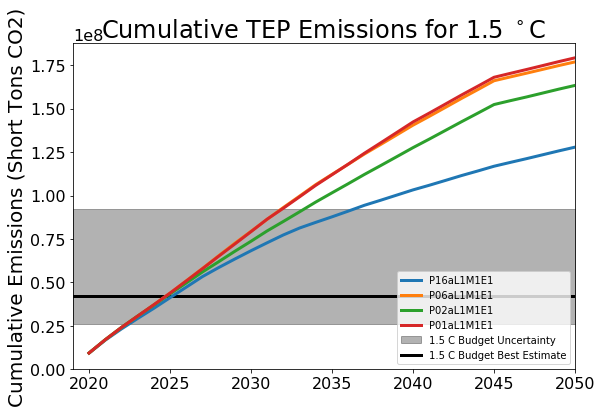

In [40]:
fig, ax = cumulative_plot()

for name, cumulative in cumulatives.items():
    ax.plot(cumulative.index, cumulative.values, zorder=10, label=name)

ax.set_ylim(0, None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:] + [handles[0]], labels[1:] + [labels[0]], loc=4)

fig.savefig(root_path / 'portfolios_1.5C.png', dpi=300)

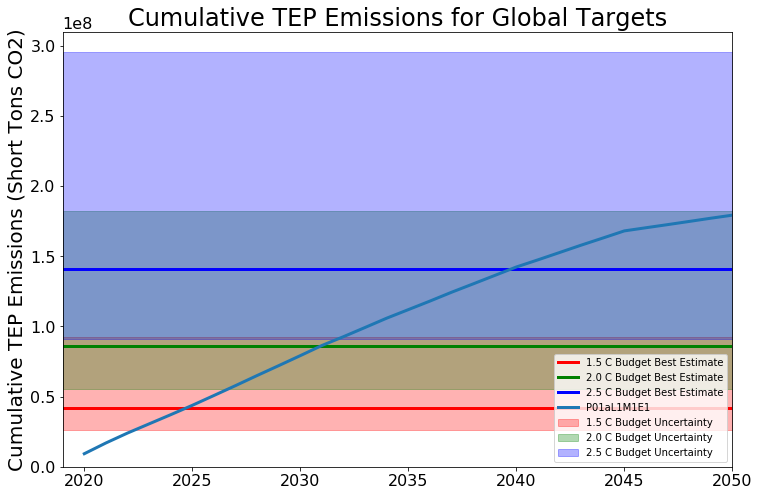

In [41]:
def cumulative_plot(carbon_budgets_tep):
    """
    Parameters
    ----------
    carbon_budget_tep : DataFrame
        
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    finite_cy_iter = iter(cycler(color=['r', 'g', 'b']))
    for target, budget in carbon_budgets_tep.items():
        styles = dict(next(finite_cy_iter))
        ax.axhline(budget['best'], label=f'{target} C Budget Best Estimate', **styles)
        ax.fill_between((cumulative.index[0] - 1, cumulative.index[-1] + 1), budget['low'], budget['high'], alpha=0.3, label=f'{target} C Budget Uncertainty', **styles)
        ax.set_xlim(cumulative.index[0] - 1, cumulative.index[-1])
    ax.set_ylabel('Cumulative TEP Emissions (Short Tons CO2)')
    ax.set_title(f'Cumulative TEP Emissions for Global Targets')
    return fig, ax

fig, ax = cumulative_plot(carbon_budgets_tep)
ax.plot(cumulative.index, cumulative.values, zorder=10, label=name)
ax.set_ylim(0, None)
ax.legend(loc=4)

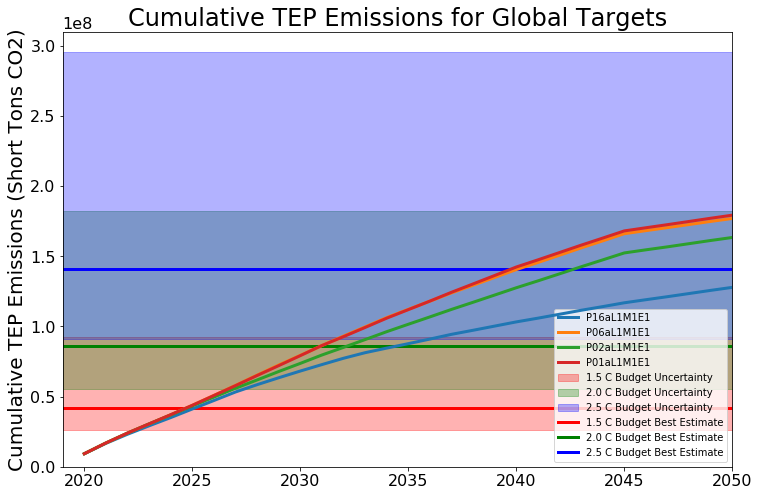

In [42]:
fig, ax = cumulative_plot(carbon_budgets_tep)

for name, cumulative in cumulatives.items():
    ax.plot(cumulative.index, cumulative.values, zorder=10, label=name)

ax.set_ylim(0, None)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:] + handles[0:3], labels[3:] + labels[0:3], loc=4)

fig.savefig(root_path / 'portfolios_1.5_2.0_2.5_C.png', dpi=300)